In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(1)


num_rows = 100
num_columns = 2


random_data = pd.DataFrame(np.random.rand(num_rows, num_columns), 
                            columns=[f'Column_{i+1}' for i in range(num_columns)])



rd = random_data.copy() 

x = 'Column_1'
y = 'Column_2'

rd.loc[:, y] = rd[y].round()


condition = rd[y] == 1
rd.loc[condition, x] = rd.loc[condition, x] + 0.25 * 0.75
rd.loc[~condition, x] = rd.loc[~condition, x] * 0.5

training_samples = num_rows // 2

x_train = rd[x][:training_samples]
y_train = rd[y][:training_samples]
x_test = rd[x][training_samples:]
y_test = rd[y][training_samples:]

print(rd)

    Column_1  Column_2
0   0.604522       1.0
1   0.000057       0.0
2   0.073378       0.0
3   0.093130       0.0
4   0.584267       1.0
..       ...       ...
95  0.131648       0.0
96  0.922566       1.0
97  1.095316       1.0
98  0.006976       0.0
99  0.804278       1.0

[100 rows x 2 columns]


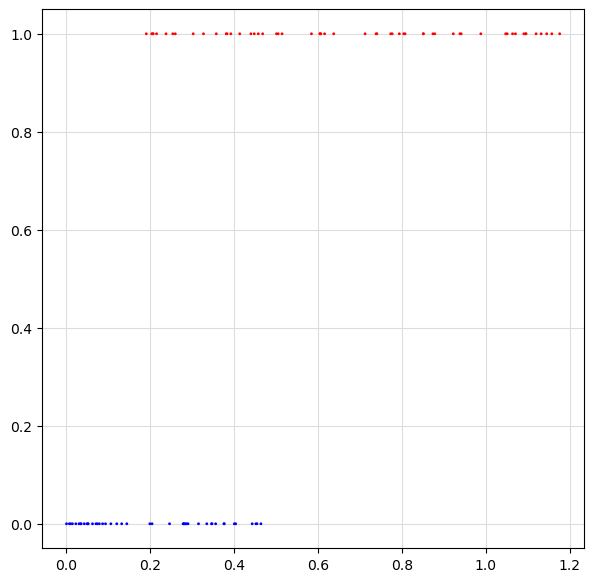

In [2]:
size = 1000 / training_samples
plt.figure(figsize=(7, 7))
threshold = 0.5

colors = np.where(rd[y] < threshold, 'blue', 'red')
plt.scatter(rd[x], rd[y], c=colors, s=1, zorder=2)

plt.grid(which='major', color='#DDDDDD', linewidth=0.8, zorder=1)

plt.show()

In [3]:
def init_slope_and_intercept(dataset):
    B0 = 0
    B1 = 0
    B = 0.0000001
    B0_list = []
    B1_list = []
    for row in range(training_samples):
        B0_list.append(0)
        B1_list.append(0)
    return B0, B1, B0_list, B1_list, B

B0, B1, B0_list, B1_list, B = init_slope_and_intercept(rd)
print(B0, B1, B0_list, B1_list)

0 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [4]:
def sigmoid(num, bias, weight):
    z = bias + weight * num
    ai = 1 / (1 + (np.e ** (-z)))

    epsilon = 1e-15
    predictions = np.clip(ai, epsilon, 1 - epsilon)
    return predictions

In [5]:
def calc_error(bias, weight, samples, dataset):
    
    n = samples
    error_sum = 0
    
    sum_dl_dw = 0
    sum_dl_db = 0
    
    for row in range(n):
        xi = x_train[row]
        yi = y_train[row]
        
        ai = sigmoid(xi, bias, weight)
        
        dl_dw = (ai - yi) * xi
        dl_db = ai - yi
        
        sum_dl_dw += dl_dw
        sum_dl_db += dl_db
        
        error_sum += yi * np.log(ai) + (1 - yi) * np.log(1 - ai)

    avg_dl_dw = sum_dl_dw / n
    avg_dl_db = sum_dl_db / n
    log_loss = error_sum / n
    
    return log_loss, avg_dl_dw, avg_dl_db
log_loss, avg_dl_dw, avg_dl_db = calc_error(B0, B1, training_samples, rd)
print(log_loss, avg_dl_dw, avg_dl_db)

-0.6931471805599446 -0.15417227973578262 -0.1


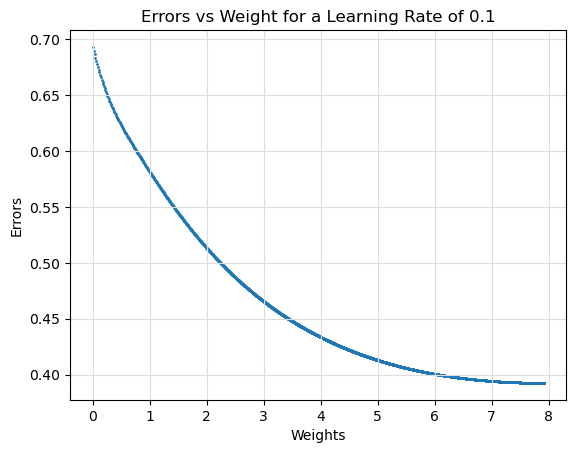

-2.5141505264973505 7.911688483854045 14411


In [6]:
def gradient_descent_of_parameters(learning_rate, max_iterations, min_step_size, bias, weight, samples, dataset):

    step_size = 1
    iteration = 0
    error_list = []
    bias_list = []
    weight_list = []
    while (iteration < max_iterations):

        log_loss, avg_dl_dw, avg_dl_db = calc_error(bias, weight, samples, dataset)
        error_list.append(log_loss)
        weight_list.append(weight)
        bias_list.append(bias)
        weight = weight - (learning_rate * avg_dl_dw)
        bias = bias - (learning_rate * avg_dl_db)
        step_size = max(abs(learning_rate * avg_dl_dw), abs(learning_rate * avg_dl_db))
        iteration += 1

        if step_size < min_step_size:
            break
            
    abs_error_list = [abs(value) for value in error_list]
    
    return bias, weight, iteration, error_list, weight_list, bias_list, abs_error_list

lr = 0.1
max_iteration = 50000
min_step_size = 0.00001
B0, B1, iteration, error_list, weight_list, bias_list, abs_error_list = gradient_descent_of_parameters(lr, max_iteration, min_step_size, B0, B1, training_samples, rd)

plt.scatter(weight_list, abs_error_list, s=1)    
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.title(f'Errors vs Weight for a Learning Rate of {lr}')
plt.xlabel('Weights')
plt.ylabel('Errors')
plt.show()

print(B0, B1, iteration)

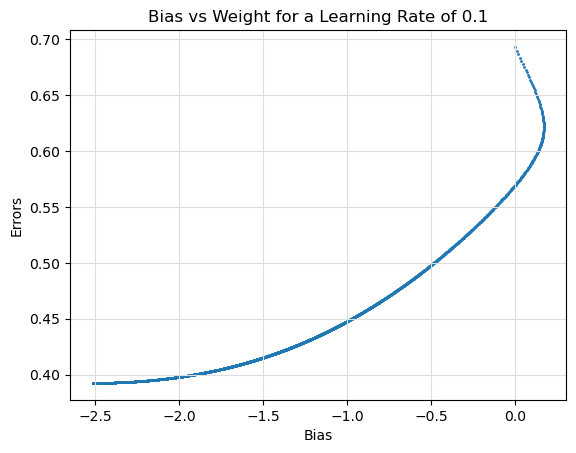

In [7]:
plt.scatter(bias_list, abs_error_list, s=1)    
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.title(f'Bias vs Weight for a Learning Rate of {lr}')
plt.xlabel('Bias')
plt.ylabel('Errors')
plt.show()

In [8]:
def test_accuracy(x_values, y_values, bias, weight, samples):
    
    correct_estimates = 0
    p_list = []
    for row in range(samples):
        xi = x_values[row+samples]
        yi = y_values[row+samples]
        
        p = sigmoid(xi, bias, weight)
        p_list.append(p)

        predicted_class = 1 if p >= 0.5 else 0
        
        if predicted_class == yi:
            correct_estimates += 1
            
    acc = (correct_estimates / samples) * 100

    return acc, p_list

# Example usage
acc, p_list = test_accuracy(x_test, y_test, B0, B1, training_samples)
print(f'Model Accuracy: {acc:.2f}%')

Model Accuracy: 82.00%


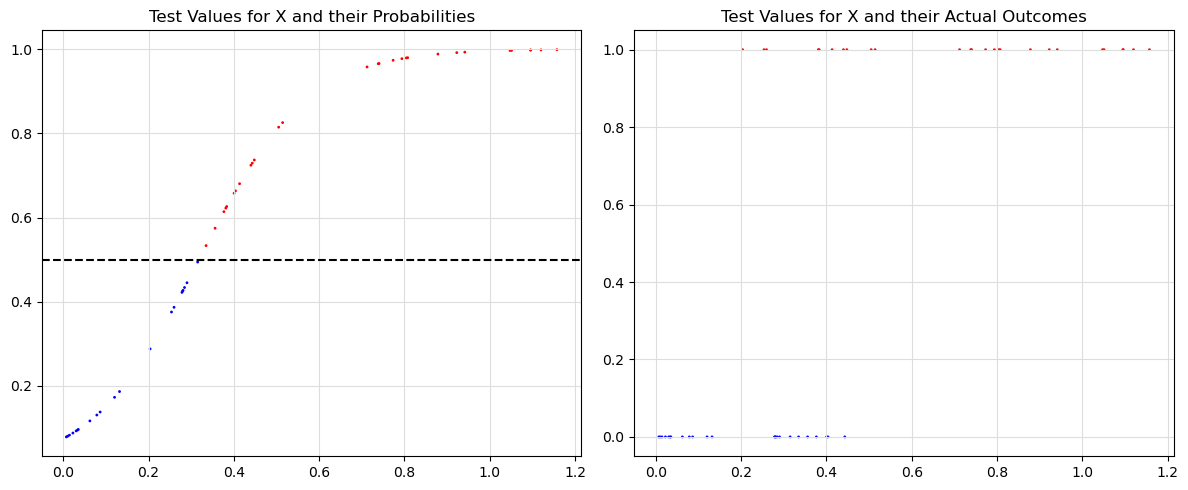

In [9]:
p_array = np.array(p_list)
colors = np.where(p_array < threshold, 'blue', 'red')    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x_test, p_list, s=1, color=colors)   
ax1.set_title('Test Values for X and their Probabilities')
ax1.axhline(y=0.5, color='black', linestyle='--')
ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)

colors = np.where(y_test < threshold, 'blue', 'red')    

ax2.scatter(x_test, y_test, s=1, color=colors)   
ax2.set_title('Test Values for X and their Actual Outcomes')

ax2.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.tight_layout()

plt.show()